In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline
from azureml import Workspace

/home/nbuser/anaconda3_23/lib/python3.4/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/nbuser/anaconda3_23/lib/python3.4/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/nbuser/anaconda3_23/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
ws = Workspace()

order_products_train_df = ws.datasets['Instacart_order_products__train.csv'].to_dataframe()
order_products_prior_df = ws.datasets['Instacart_order_products__prior.csv'].to_dataframe()
orders_df = ws.datasets["Instacart_orders.csv"].to_dataframe()
products_df = ws.datasets["Instacart_products.csv"].to_dataframe()
aisles_df = ws.datasets["Instacart_aisles.csv"].to_dataframe()
departments_df = ws.datasets["Instacart_departments.csv"].to_dataframe()

In [4]:
# visualise imported datasets
orders_df.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [5]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [6]:
order_products_train_df.head(10)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
5,1,13176,6,0
6,1,47209,7,0
7,1,22035,8,1
8,36,39612,1,0
9,36,19660,2,1


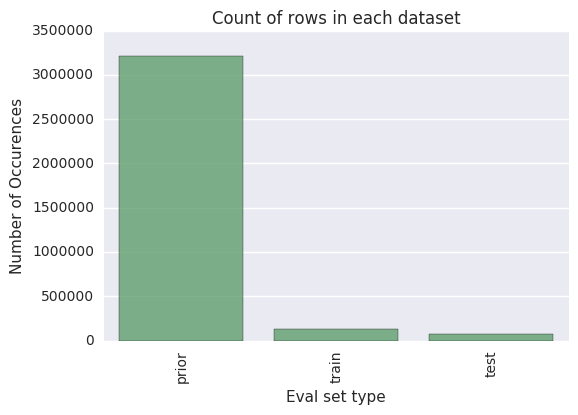

eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

In [7]:
# Lets get count of rows in each of the three sets["prior", "train" and "test"] in "orders_df"

cnt_srs = orders_df["eval_set"].value_counts()
plt.figure()
sns.barplot( cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel("Number of Occurences")
plt.xlabel("Eval set type")
plt.title("Count of rows in each dataset")
plt.xticks(rotation='vertical')
plt.show()

def get_unique_count(x):
    return len(np.unique(x))

cnt_srs = orders_df.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs

Findings: There are 206209 customers in total of which 131209 customers are given as train set and we need to predict for rest 75000 customers

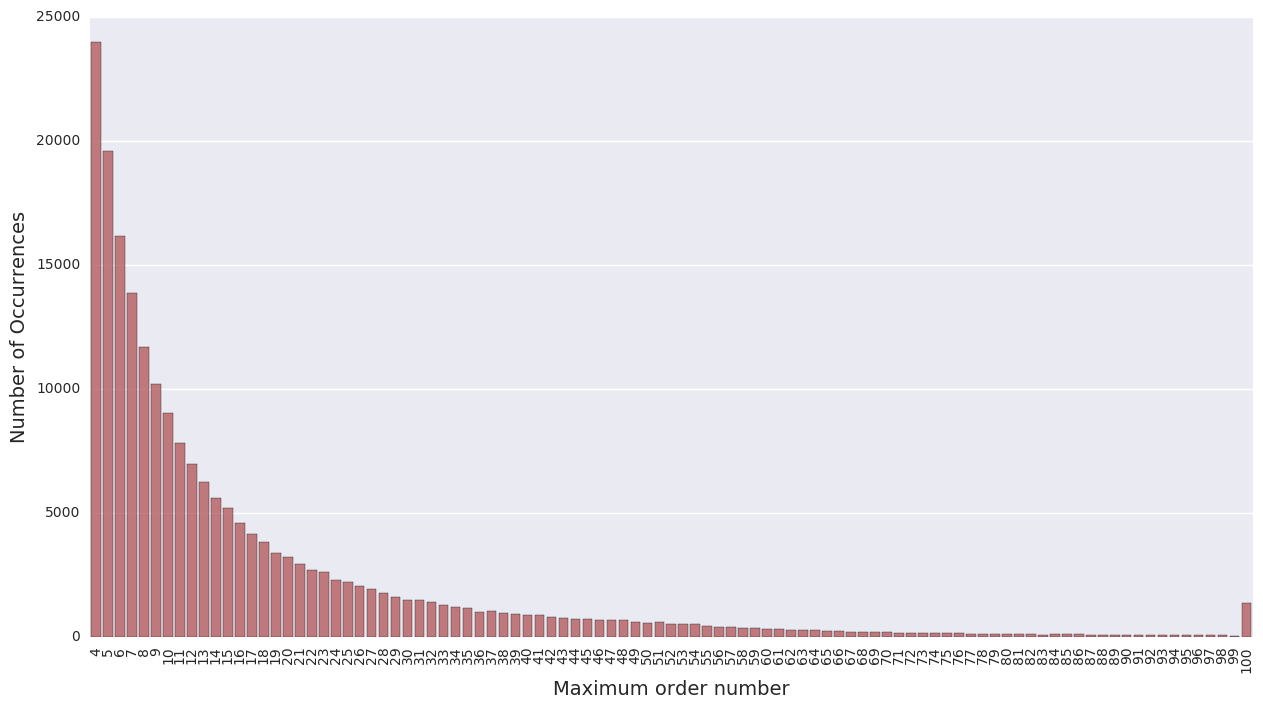

In [8]:
# Lets validate tha claim that  4 to 100 orders of a customer are given

cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()

cnt_srs = cnt_srs["order_number"].value_counts()

plt.figure(figsize=(15,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences',fontsize=14)
plt.xlabel('Maximum order number',fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

Findings: so the number of orders for a customer is in the range of 4 to 100

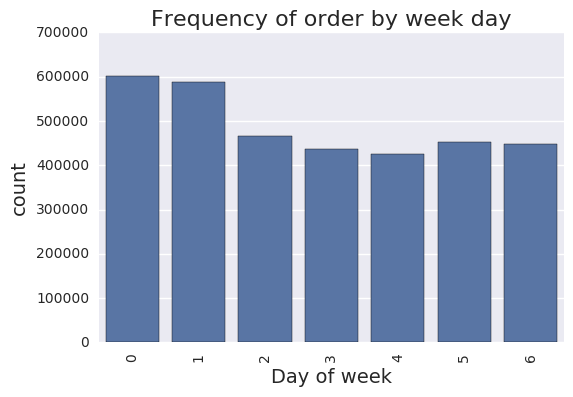

In [9]:
# Let us see the weekly order behaviour

plt.figure()
sns.countplot(x="order_dow", data=orders_df, color=color[0])
plt.ylabel("count",fontsize=14)
plt.xlabel("Day of week",fontsize=14)
plt.title("Frequency of order by week day",fontsize=16)
plt.xticks(rotation='vertical')
plt.show()

Findings: Looks like 0 and 1 are saturday and sunday looking at the order frequency

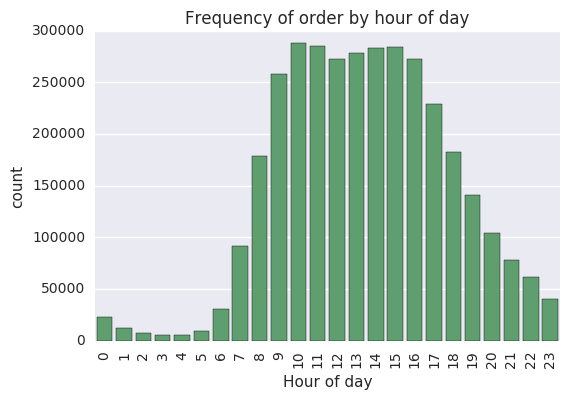

In [10]:
# lets look at the order distribution wrt time of the day

plt.figure()
sns.countplot(x="order_hour_of_day", data=orders_df, color=color[1])
plt.ylabel("count")
plt.xlabel("Hour of day")
plt.title("Frequency of order by hour of day")
plt.xticks(rotation='vertical')
plt.show()

Findings: Majority of the orders are made during the day time.

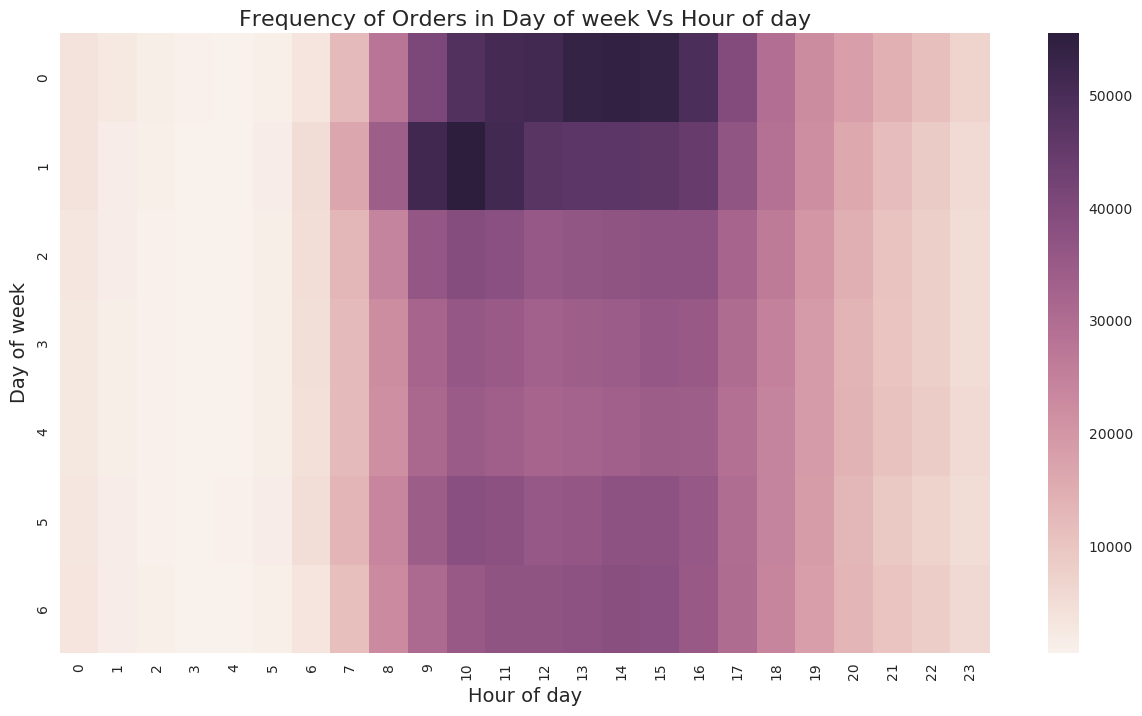

In [11]:
# Let us visualise orders density for both weekdays and hour of the day

grouped_df = orders_df.groupby(["order_dow","order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot("order_dow", "order_hour_of_day", "order_number")

plt.figure(figsize=(15,8))
sns.heatmap(grouped_df)
plt.title("Frequency of Orders in Day of week Vs Hour of day",fontsize=16)
plt.xlabel("Hour of day",fontsize=14)
plt.ylabel("Day of week",fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

Findings: Looks like saturday and sunday evenings have more orders

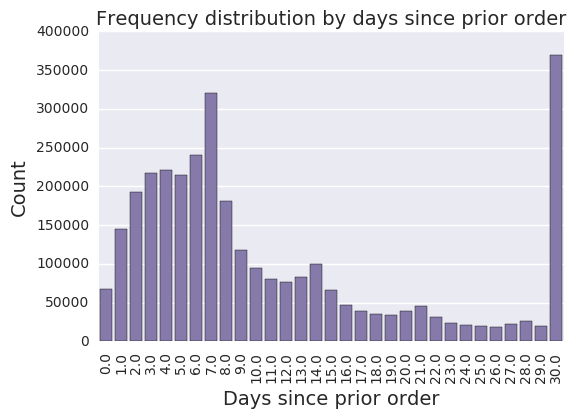

In [12]:
# Let us check the time interval between orders

plt.figure()
sns.countplot(x = "days_since_prior_order", data=orders_df, color=color[3])
plt.ylabel("Count",fontsize=14)
plt.xlabel("Days since prior order",fontsize=14)
plt.title("Frequency distribution by days since prior order",fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

Findings: Looks like customers order once in every week or once in every month

In [13]:
# Lets checkout reorder percentage in prior and training set
print("orders percentage of Prior set which do contains re-ordered items: ")
order_products_prior_df["reordered"].sum()/order_products_prior_df.shape[0]

orders percentage of Prior set which do contains re-ordered items: 


0.5896974667922161

In [14]:
print("orders percentage of Train set which contains re-ordered items: ")
order_products_train_df["reordered"].sum()/order_products_train_df.shape[0]

orders percentage of Train set which contains re-ordered items: 


0.5985944127509629

Findings: On average 58% to 59% in an order are re-ordered products

In [15]:
# Lets check orders percentage which dont have any re-ordered item

grouped_df = order_products_prior_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1
print("orders percentage of Prior set which do not have any re-ordered item: ")
grouped_df["reordered"].value_counts() / grouped_df.shape[0]

orders percentage of Prior set which do not have any re-ordered item: 


1    0.879151
0    0.120849
Name: reordered, dtype: float64

In [16]:
print("orders percentage of Train set which do not have any re-ordered item: ")
grouped_df = order_products_train_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1
grouped_df["reordered"].value_counts() / grouped_df.shape[0]

orders percentage of Train set which do not have any re-ordered item: 


1    0.93444
0    0.06556
Name: reordered, dtype: float64

Findings: So, about 12% of the orders in prior set has no re-ordered items while in the train set, it is 6.5%

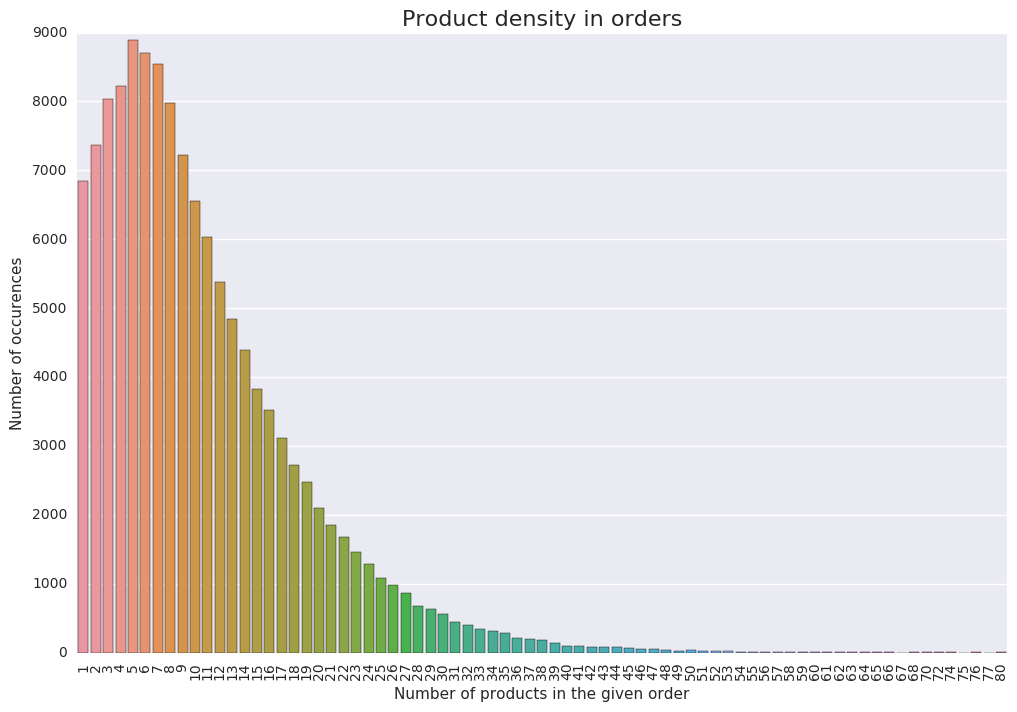

In [17]:
# Let us see the number of products bought in each order

grouped_df = order_products_train_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df["add_to_cart_order"].value_counts()

plt.figure(figsize=(12,8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values)
plt.title("Product density in orders",fontsize=16)
plt.xlabel("Number of products in the given order")
plt.ylabel("Number of occurences")
plt.xticks(rotation='vertical')
plt.show()

Findings: Most orders contain 5 products. And the products distribution is right skewed

In [18]:
# Now lets explore Product details

products_df.head(10)
aisles_df.head(10)
departments_df.head(10)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


In [19]:
# Lets merge products_d, departments_df, aisles_df with order_products__ files

order_products_prior_df = pd.merge(order_products_prior_df, products_df, 
                                   on = "product_id", how="left")

order_products_prior_df = pd.merge(order_products_prior_df, aisles_df,
                                   on = "aisle_id", how="left")

order_products_prior_df = pd.merge(order_products_prior_df, departments_df, 
                                   on = "department_id", how="left")
order_products_prior_df.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry
5,2,17794,6,1,Carrots,83,4,fresh vegetables,produce
6,2,40141,7,1,Original Unflavored Gelatine Mix,105,13,doughs gelatins bake mixes,pantry
7,2,1819,8,1,All Natural No Stir Creamy Almond Butter,88,13,spreads,pantry
8,2,43668,9,0,Classic Blend Cole Slaw,123,4,packaged vegetables fruits,produce
9,3,33754,1,1,Total 2% with Strawberry Lowfat Greek Strained...,120,16,yogurt,dairy eggs


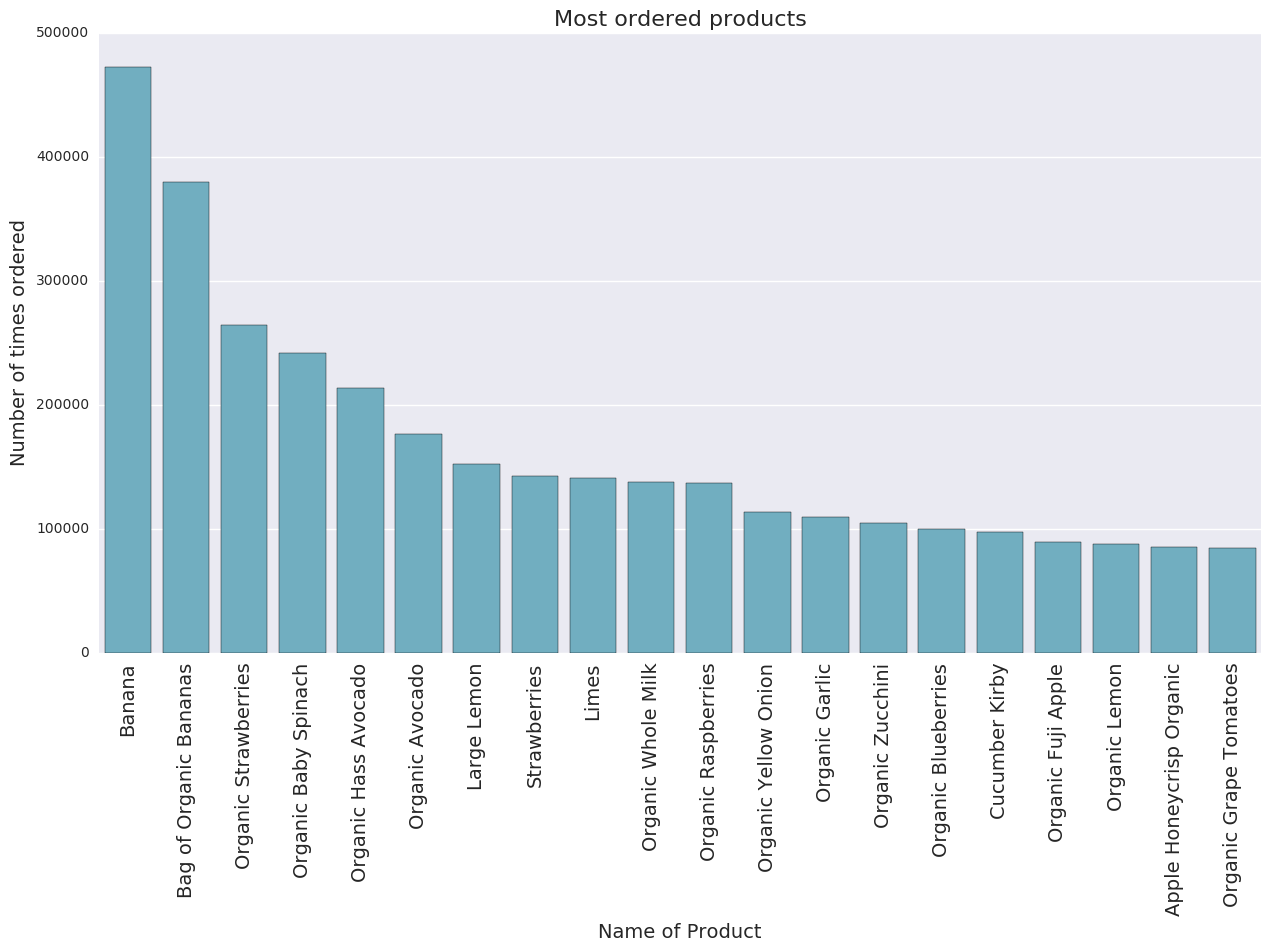

In [20]:
# lets look at most ordered products

cnt_srs = order_products_prior_df["product_name"].value_counts().reset_index().head(20)
cnt_srs.columns = ["product_name", "frequency_count"]
cnt_srs

plt.figure(figsize=(15,8))
sns.barplot(cnt_srs.product_name, cnt_srs.frequency_count, color=color[5])
plt.title("Most ordered products",fontsize=16)
plt.xlabel("Name of Product",fontsize=14)
plt.ylabel("Number of times ordered",fontsize=14)
plt.xticks(rotation='vertical',fontsize=14)
plt.show()

Findings: Most of the frequenctly ordered products are Organic! thats great!!

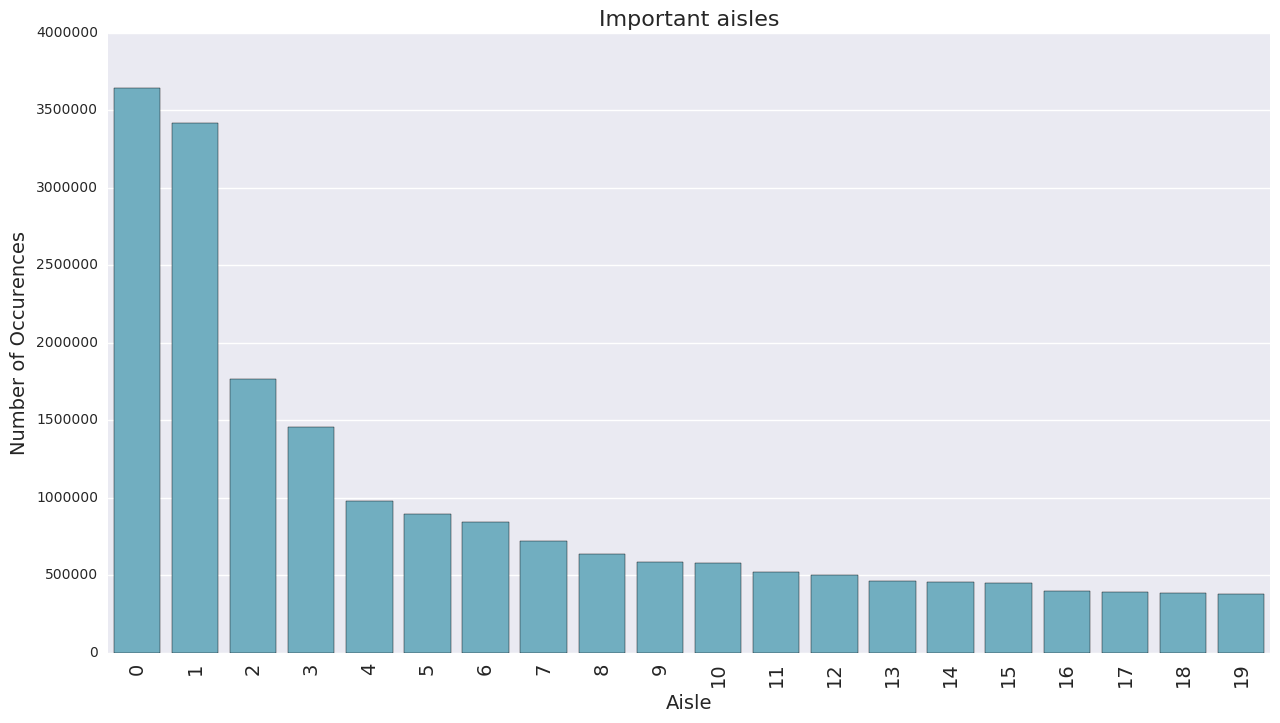

In [21]:
# Lets look at important aisles

cnt_srs = order_products_prior_df["aisle"].value_counts().reset_index().head(20)

plt.figure(figsize=(15,8))
sns.barplot(cnt_srs.index, cnt_srs.aisle, color=color[5])
plt.title("Important aisles",fontsize=16)
plt.xlabel("Aisle",fontsize=14)
plt.ylabel("Number of Occurences",fontsize=14)
plt.xticks(rotation='vertical',fontsize=14)
plt.show()

Findings: Top two aisles are fresh fruits and fresh vegetables


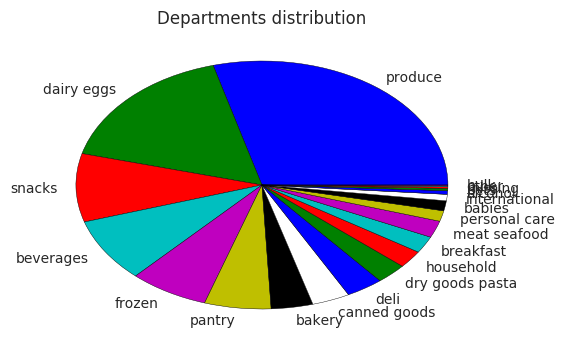

In [22]:
# Lets explore department distribution


temp_series = order_products_prior_df["department"].value_counts()
plt.figure()
labels = (np.array(temp_series.index))
sizes = (np.array( (temp_series / temp_series.sum())*100) )
plt.pie(sizes, labels=labels)
plt.title("Departments distribution")
plt.show()

Findings: We can see that produce is the largest department.

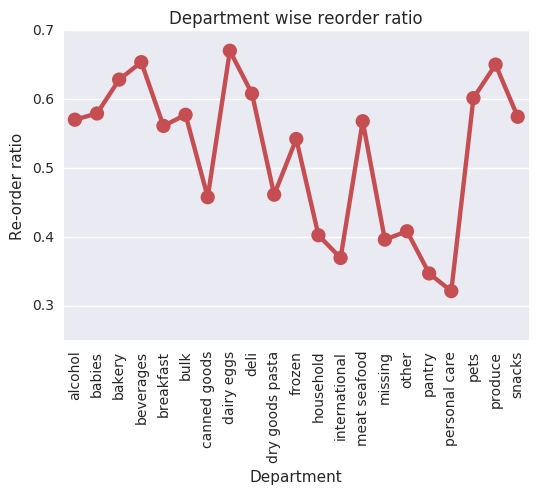

In [23]:
# Lets explore re-ordered feature

grouped_df = order_products_prior_df.groupby("department")["reordered"].aggregate("mean").reset_index()

plt.figure()
sns.pointplot(grouped_df["department"].values, grouped_df["reordered"].values, color=color[2])
plt.ylabel("Re-order ratio")
plt.xlabel("Department")
plt.title("Department wise reorder ratio")
plt.xticks(rotation="vertical")
plt.show()

Findings: Personal care has lowest re-order ratio and dairy-eggs have highest reorder ratio

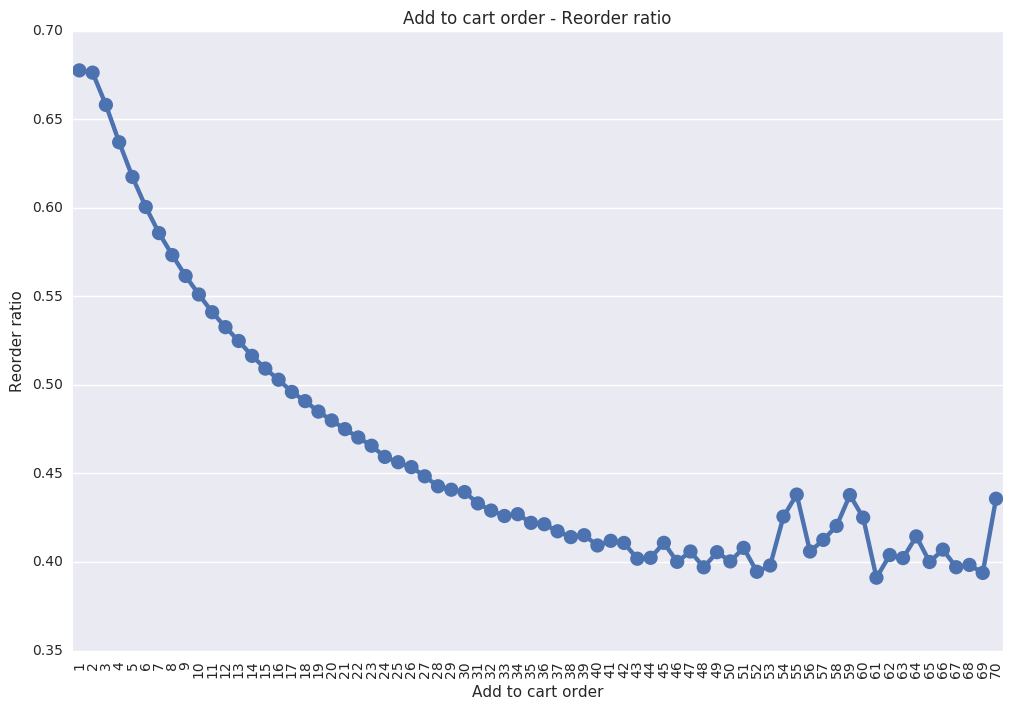

In [24]:
# Let us explore relationhsip between how order of adding the product to the cart affects the reorder ratio


order_products_prior_df["add_to_cart_order_mod"] = order_products_prior_df["add_to_cart_order"].copy()
order_products_prior_df["add_to_cart_order_mod"].loc[order_products_prior_df["add_to_cart_order_mod"]>70]=70
grouped_df = order_products_prior_df.groupby("add_to_cart_order_mod")["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df["add_to_cart_order_mod"].values,
              grouped_df["reordered"].values)
plt.title("Add to cart order - Reorder ratio")
plt.xlabel("Add to cart order")
plt.ylabel("Reorder ratio")
plt.xticks(rotation="vertical")
plt.show()

Findings: Looks like products which are added to the cart initially are more likely to be reordered again when compared to the ones added later

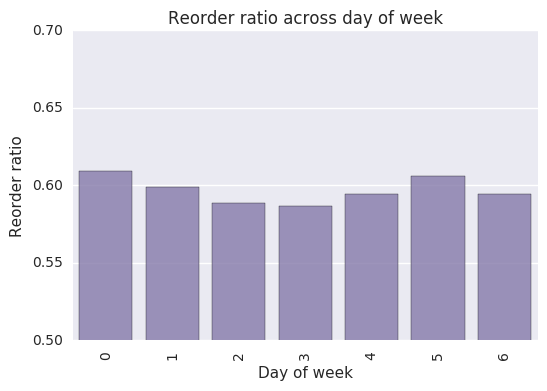

In [25]:
# Lets explore reorder ratio across day of week


order_products_train_df = pd.merge(order_products_train_df, orders_df, on='order_id', how='left')
grouped_df = order_products_train_df.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure()
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio')
plt.xlabel('Day of week')
plt.title("Reorder ratio across day of week")
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

Findings: looks like orders placed during Saturday and Thursday have higher reordered items

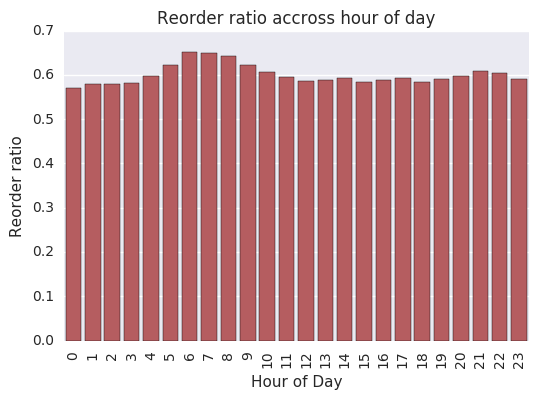

In [26]:
# Lets explore reorder ratio across hour of day


grouped_df = order_products_train_df.groupby("order_hour_of_day")["reordered"].aggregate("mean").reset_index()

plt.figure()
sns.barplot(grouped_df["order_hour_of_day"].values, grouped_df["reordered"].values, color=color[2])
plt.title("Reorder ratio accross hour of day")
plt.xlabel("Hour of Day")
plt.ylabel("Reorder ratio")
plt.xticks(rotation="vertical")
plt.show()

Findings: Looks like orders which were placed during early morning (6am, 7am) have higher reorder ratio

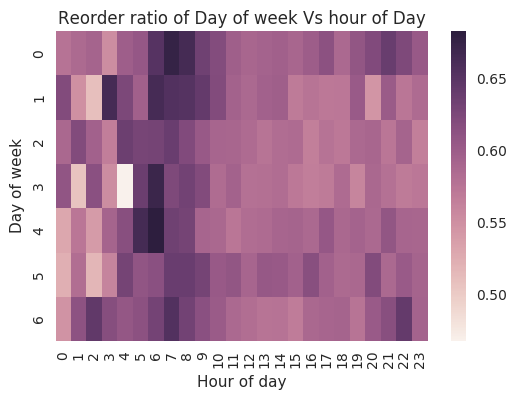

In [27]:
# Lets explore reorder ratio of week vs hour of day


grouped_df = order_products_train_df.groupby(["order_dow","order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot("order_dow", "order_hour_of_day", "reordered")

plt.figure()
sns.heatmap(grouped_df)
plt.title("Reorder ratio of Day of week Vs hour of Day")
plt.xlabel("Hour of day")
plt.ylabel("Day of week")
plt.xticks(rotation="vertical")
plt.show() 